# Applying Grad-CAM to a sample image

## Imports

In [1]:
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path: sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
import cv2
import math
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from gradcam_utils import *

Using TensorFlow backend.
/home/ruthz/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ruthz/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ruthz/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ruthz/.local/lib/python3.5/site-packages/tensorflow/python/fra

## Load data

In [2]:
DATASET_ROOT = 'data/test'
#GT_ROOT = '../m/ground_truth'
CLASSES = ['carpet', 'grid', 'leather', 'tile', 'wood']

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(DATASET_ROOT,
                                                    class_mode='categorical',
                                                    interpolation='bilinear',
                                                    target_size=(224, 224),
                                                    batch_size=16,
                                                    shuffle=False,
                                                    classes=CLASSES)
unique, counts = np.unique(test_generator.labels, return_counts=True)
print(dict(zip(CLASSES, counts)))

Found 515 images belonging to 5 classes.
{'leather': 124, 'carpet': 117, 'tile': 117, 'wood': 79, 'grid': 78}


## Load model

In [3]:
model = load_model('save/texturenet.h5')
for l in model.layers:
    print(l.name)



conv2d_1
conv2d_2
max_pooling2d_1
conv2d_3
conv2d_4
max_pooling2d_2
conv2d_5
conv2d_6
conv2d_7
global_average_pooling2d_1
dense_1


## Get Grad-CAM weights

In [4]:
alpha, layer = get_grad_cam_weights(model, np.zeros((1, 224, 224, 3)))

(256, 5)


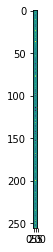

In [5]:
print(alpha.shape)
plt.imshow(alpha)

In [6]:
print(layer)

conv2d_7


## Load image batch

In [7]:
start_idx = 0
end_idx = 15
cur_batch_sz = end_idx - start_idx + 1
img_batch = read_batch(test_generator.directory, test_generator.filenames[start_idx:end_idx + 1], cur_batch_sz,
                           (224, 224))

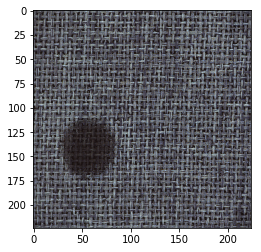

In [8]:
plt.imshow(img_batch[0])

In [9]:
print(test_generator.filenames[514])

wood/wood_test_scratch_020.png


## Predict texture class

In [10]:
pred_scores = model.predict(img_batch /255)
is_pass_threshold = np.zeros((cur_batch_sz, len(CLASSES)))
is_pass_threshold[np.arange(cur_batch_sz), np.argmax(pred_scores, axis=1)] = 1
print(is_pass_threshold)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


## Run Grad-CAM

Ignoring non-maximum classes:

In [11]:
Y = grad_cam(model, alpha, img_batch / 255, is_pass_threshold, layer, pred_scores,
             orig_sz=img_batch.shape[1:3], should_upsample=True)

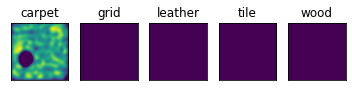

In [12]:
plt.figure()
for i in range(len(CLASSES)):
    plt.subplot(151+i)
    plt.imshow(Y[0, :, :, i])
    plt.title(CLASSES[i])
    plt.xticks([])
    plt.yticks([])

Including non-maximum classes:

In [12]:
Y = grad_cam(model, alpha, img_batch / 255, np.ones((cur_batch_sz, len(CLASSES))), layer, pred_scores,
             orig_sz=img_batch.shape[1:3], should_upsample=True)

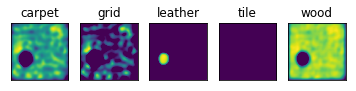

In [14]:
plt.figure()
for i in range(len(CLASSES)):
    plt.subplot(151+i)
    plt.imshow(Y[0, :, :, i])
    plt.title(CLASSES[i])
    plt.xticks([])
    plt.yticks([])

In [16]:
train_carpet_idx = np.full(len(is_pass_threshold),False)
train_grid_idx = np.full(len(is_pass_threshold),False)
train_leather_idx = np.full(len(is_pass_threshold),False)
train_tile_idx = np.full(len(is_pass_threshold),False)
train_wood_idx = np.full(len(is_pass_threshold),False)
for i in range(len(is_pass_threshold)):
    pred_class = np.where(is_pass_threshold[i,:]==1)
    #print(pred_class[0])
    if pred_class[0] == 0 :
        train_carpet_idx[i] = True
    if pred_class[0] == 1 :
        train_grid_idx[i] = True
    if pred_class[0] == 2 :
        train_leather_idx[i] = True
    if pred_class[0] == 3 :
        train_tile_idx[i] = True
    if pred_class[0] == 4 :
        train_wood_idx[i] = True

In [10]:
is_pass_threshold[:,0]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.